<a href="https://colab.research.google.com/github/slimf1/ZZ3-DL/blob/main/06_Transfer_Learning_Keras_etud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fine Tuning



Objectif : utiliser un réseau pré entraîné et une technique de Fine Tuning pour apprendre une classification de données personnelles. Les données étant en nombre insuffisant, une technique d'augmentation de données sera utilisée.

## Imports

In [10]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint


In [11]:
# Paramètres 
image_shape = (224, 224, 3)
image_size = image_shape[:2]

batch_size = 32
num_classes = 5


## Données 

In [12]:
def Data():
    data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos',cache_dir = '/Users/vibarra/Documents/Cours/ISIMA/DeepLearning/TPPython/data',untar=True)
    data_dir = pathlib.Path(data_dir)

    print("Nombre d'images :", len(list(data_dir.glob('*/*.jpg'))))

    classes = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    print("Classes : ",classes)

    # Cf doc keras

    # Augmentation de données : 75% entraînement, 25% test
    # image_gen = ImageDataGenerator(
    #   rotation_range=20,
    #   width_shift_range=0.2,
    #   height_shift_range=0.2,
    #   rescale=1./255,
    #   brightness_range=(0.2, 1.2),
    #   horizontal_flip=True,  
    #   validation_split=0.25)
    
    image_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, validation_split=0.25)
    # rescale, rotation range=20, validation_split_25

    # directory=str(data_dir), batch_size=batch_size, classes=list(classes), target_size=image_size ([0] [1]), shuffle=True, subset="training"
    # Augmentation de la base d'entraînement
    train_data_gen = image_gen.flow_from_directory(data_dir, class_mode="categorical", batch_size=batch_size, target_size=image_size, shuffle=True, subset='training')
    # Augmentation de la base de test/validation
    test_data_gen = image_gen.flow_from_directory(data_dir, class_mode="categorical", batch_size=batch_size, target_size=image_size, shuffle=True, subset='validation')
    # class mode = categ? binary ?

    return train_data_gen, test_data_gen, classes

x_train, x_test, classes = Data()

Nombre d'images : 3670
Classes :  ['sunflowers' 'dandelion' 'daisy' 'tulips' 'roses']
Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


In [20]:
def TransferModel(input_shape,stop_freeze):

  pretrained_model = MobileNetV2(input_shape=[*image_size, 3], include_top=False)
  pretrained_model.layers.pop()

  for layer in pretrained_model.layers[:-stop_freeze]:
    layer.trainable = False

  model = Sequential()
  model.add(pretrained_model)
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  return model


## Réseau 

In [17]:
num_epochs = 10
stop_freeze = 4

# Chargement des données augmentées
x_train, x_test, classes = Data()

# Modèle
model = TransferModel(input_shape=image_shape,stop_freeze = stop_freeze)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Callback pour la sauvegarde du meilleur modèle
if not os.path.isdir("sauve"):
    os.mkdir("sauve")
    
checkpoint = ModelCheckpoint("sauve/MobileNetV2_flowers-loss-{val_loss:.2f}-acc-{accuracy:.2f}.h5",
                                save_best_only=True,verbose=1)

train_steps_epoch = np.ceil(x_train.samples / batch_size)
val_steps_epoch = np.ceil(x_test.samples / batch_size)

# Entraînement
model.fit(x_train, steps_per_epoch=train_steps_epoch,
                        validation_data=x_test, validation_steps=val_steps_epoch,
                        epochs=num_epochs, verbose=1, callbacks=[checkpoint])

Nombre d'images : 3670
Classes :  ['sunflowers' 'dandelion' 'daisy' 'tulips' 'roses']
Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.
9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 2.5175 - accuracy: 0.7739
Epoch 00001: val_loss improved from inf to 7.04810, saving model to sauve/MobileNetV2_flowers-loss-7.05-acc-0.77.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


87/87 [==============================] - 58s 634ms/step - loss: 2.5175 - accuracy: 0.7739 - val_loss: 7.0481 - val_accuracy: 0.6798
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 1.2466 - accuracy: 0.9020
Epoch 00002: val_loss improved from 7.04810 to 4.42890, saving model to sauve/MobileNetV2_flowers-loss-4.43-acc-0.90.h5
87/87 [==============================] - 54s 624ms/step - loss: 1.2466 - accuracy: 0.9020 - val_loss: 4.4289 - val_accuracy: 0.8011
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.9394
Epoch 00003: val_loss did not improve from 4.42890
87/87 [==============================] - 54s 623ms/step - loss: 0.9070 - accuracy: 0.9394 - val_loss: 5.0575 - val_accuracy: 0.8153
Epoch 4/10
87/87 [==============================] - ETA: 0s - loss: 0.7267 - accuracy: 0.9445
Epoch 00004: val_loss did not improve from 4.42890
87/87 [==============================] - 53s 615ms/step - loss: 0.7267 - accuracy: 0.9445 - val_loss

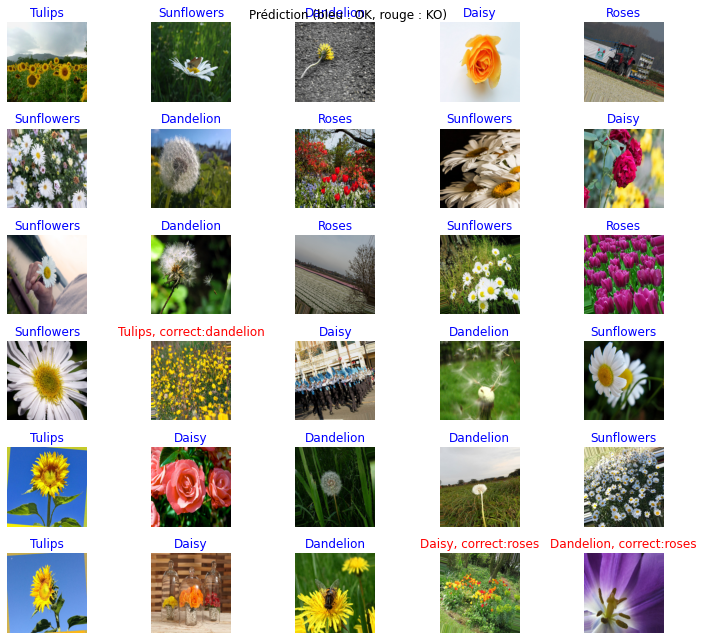

In [18]:
# Quelques exemples de bonne / mauvaise classification
image_batch, label_batch = next(iter(x_test))

label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)